In [2]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
df = pd.read_csv("data-p2/patients_interactions_mimic3d.csv")
df.shape

(2976, 1597)

In [4]:
y = df["LOSdays"]

x1 = df['NumTransfers']
x2 = df['NumCallouts admit_type_EMERGENCY']
x3 = df['NumDiagnosis NumTransfers']
x4 = df['NumChartEvents admit_type_NEWBORN']
x5 = df['admit_type_NEWBORN admit_location_CLINIC REFERRAL/PREMATURE']

# x1 = df['NumCallouts']
# x2 = df['NumCallouts NumTransfers']
# x3 = df['NumRx AdmitProcedure_4']
# x4 = df['NumTransfers insurance_Private']
# x5 = df['NumChartEvents admit_type_NEWBORN']

# x1 = df["NumTransfers admit_type_EMERGENCY"]
# x2 = df["NumCallouts"]
# x3 = df["NumCallouts NumProcs"]
# x4 = df["NumTransfers insurance_Medicare"]
# x5 = df["NumTransfers insurance_Private"]

In [5]:
# (Intercept)  1.016e+01  5.054e-02  201.11   <2e-16 ***
# x1          -1.469e+00  2.513e-02  -58.45   <2e-16 ***
# x2          -1.424e+01  3.179e-01  -44.79   <2e-16 ***
# x3           6.560e-03  2.040e-04   32.16   <2e-16 ***
# x4           1.465e-02  3.187e-04   45.97   <2e-16 ***
# x5           1.421e+01  2.682e-01   52.98   <2e-16 ***

SyntaxError: invalid syntax (208802111.py, line 1)

In [40]:
with pm.Model() as model:
    intercept = pm.Normal('Intercept', mu=float(1.016e+01), sigma=100)
    slope_1 = pm.Normal('NumTransfers', mu=float(-1.469e+00), sigma=100)
    slope_2 = pm.Normal('Interaction Between NumCallouts and admit_type_EMERGENCY', mu=float(-1.424e+01), sigma=100)
    slope_3 = pm.Normal('Interaction Between NumDiagnosis and NumTransfers', mu=float(6.560e-03), sigma=100)
    slope_4 = pm.Normal('Interaction Between NumChartEvents and admit_type_NEWBORN', mu=float(1.465e-02), sigma=100)
    slope_5 = pm.Normal('Interaction Between admit_type_NEWBORN and admit_location_CLINIC REFERRAL/PREMATURE', mu=float(1.421e+01), sigma=100)
    
    sigma = pm.Exponential('Standard Deviation', lam=0.0001)
    
    mu = (intercept
          + slope_1 * x1 
          + slope_2 * x2
          + slope_3 * x3
          + slope_4 * x4
          + slope_5 * x5
    )
    
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y)
    
    trace = pm.sample(draws=10000, tune=5000,return_inferencedata=True, progressbar=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, NumTransfers, Interaction Between NumCallouts and admit_type_EMERGENCY, Interaction Between NumDiagnosis and NumTransfers, Interaction Between NumChartEvents and admit_type_NEWBORN, Interaction Between admit_type_NEWBORN and admit_location_CLINIC REFERRAL/PREMATURE, Standard Deviation]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 136 seconds.


In [41]:
trace_df = az.extract(trace).to_dataframe()

# Save the DataFrame to a CSV file
trace_df.to_csv('data-p2/trace_output.csv', index=False)

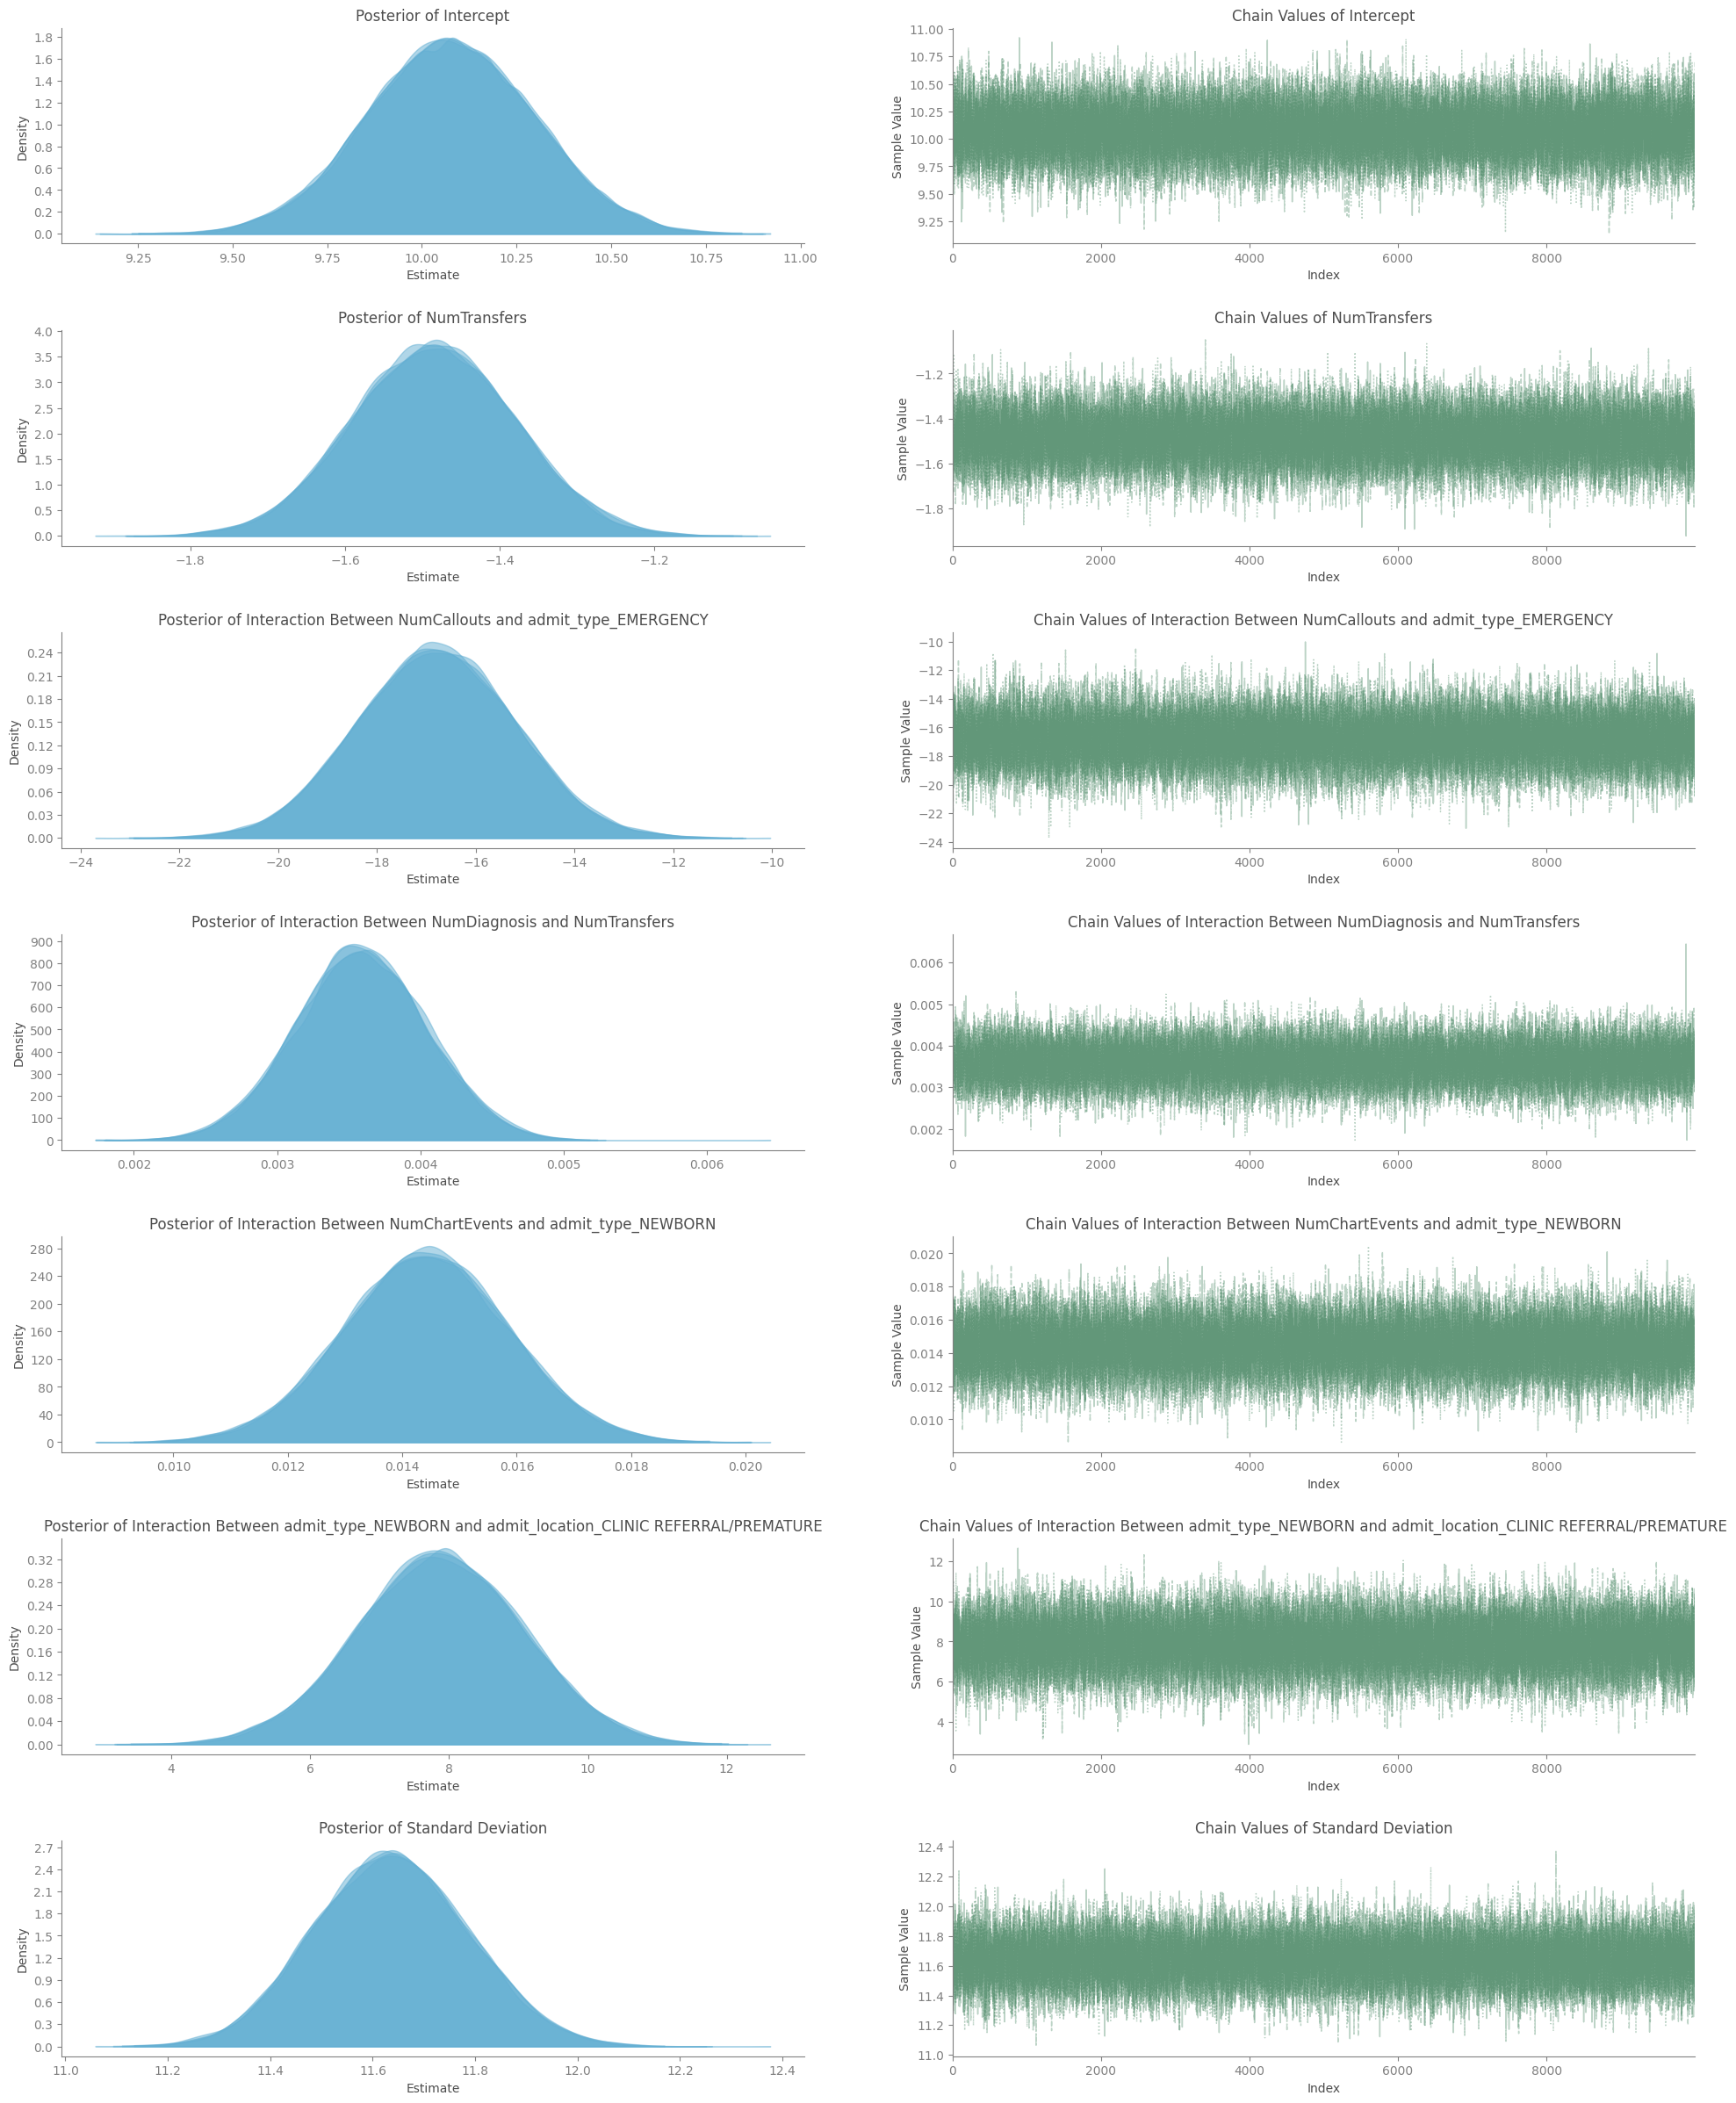

In [62]:
axes = az.plot_trace(trace, figsize=(24, 30), plot_kwargs={'alpha':0},fill_kwargs={'alpha': 0.5, 'color': '#63afd3'})

for i, ax in enumerate(axes[:, 1]):  # Right column for the chain plots
    for line in ax.get_lines():  # Iterate over lines in the trace plot
        line.set_color('#41825d')  # Set the color of the chain plots to red


for ax in axes.ravel():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    
    ax.tick_params(axis='both', which='both', colors='gray')

plt.subplots_adjust(hspace=0.4)

for i, ax in enumerate(axes[:, 0]):
    ax.set_xlabel("Estimate", color='#4d4d4d')
    ax.set_ylabel("Density", color='#4d4d4d')
    ax.set_title(f"Posterior of {ax.get_title()}", color='#4d4d4d')
    ax.yaxis.set_major_locator(plt.MaxNLocator())

for i, ax in enumerate(axes[:, 1]):
    ax.set_title(f"Chain Values of {ax.get_title()}", color='#4d4d4d')
    ax.set_xlabel("Index", color='#4d4d4d')
    ax.set_ylabel("Sample Value", color='#4d4d4d')

plt.show()


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'NumTransfers'}>,
        <Axes: title={'center': 'NumCallouts admit_type_EMERGENCY'}>],
       [<Axes: title={'center': 'NumDiagnosis NumTransfers'}>,
        <Axes: title={'center': 'NumChartEvents admit_type_NEWBORN'}>,
        <Axes: title={'center': 'admit_type_NEWBORN admit_location_CLINIC REFERRAL/PREMATURE'}>],
       [<Axes: title={'center': 'sigma'}>, <Axes: >, <Axes: >]],
      dtype=object)

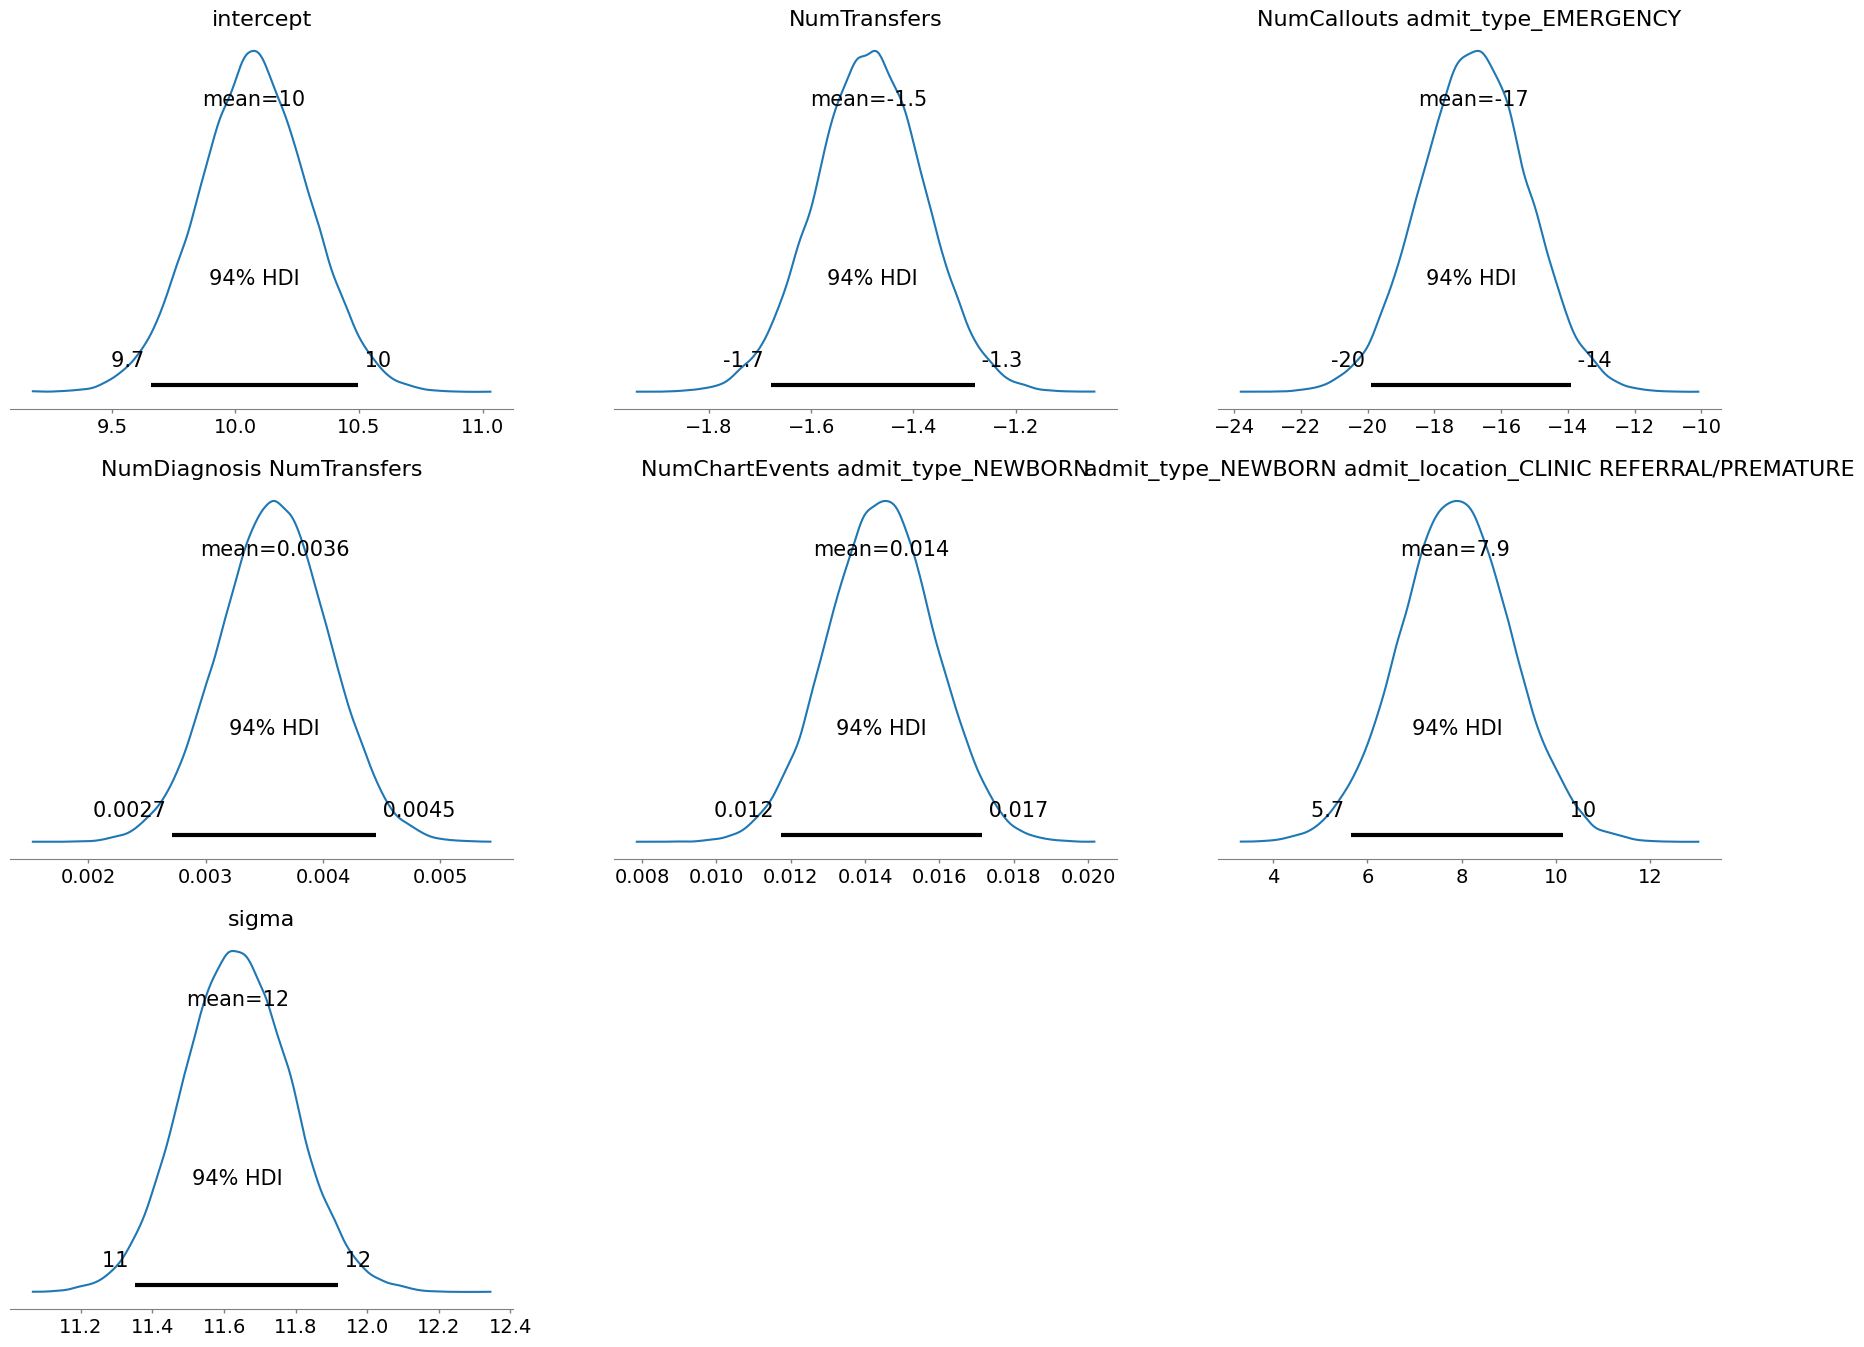

In [8]:
az.plot_posterior(trace)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

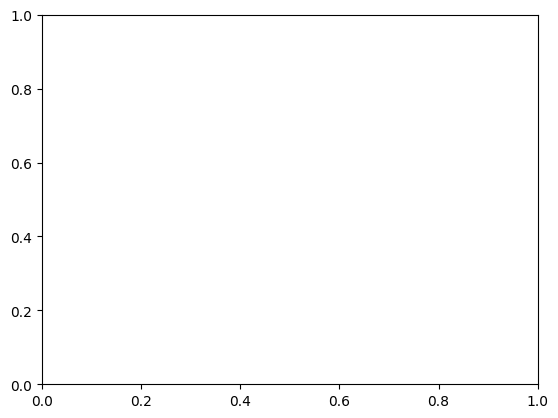

In [31]:
az.plot_dist(trace)

In [53]:
posterior_predictive_samples = posterior_predictive.posterior_predictive

# Now, extract the predicted values for 'y'
y_pred_samples = posterior_predictive_samples['y']

# Calculate the probability that y > 2
prob_greater_than_2 = np.mean(y_pred_samples > 2)

print(f"The probability that y is greater than 2 is: {prob_greater_than_2:.3f}")

The probability that y is greater than 2 is: 0.740


In [55]:
# Step 2: Compute the condition (values > 2)
condition = y > 2

# Step 3: Calculate the probability
prob_greater_than_2 = condition.mean()

# Output the result
print(f"The probability that values in the column are greater than 2 is: {prob_greater_than_2:.3f}")

The probability that values in the column are greater than 2 is: 0.893
